In [1]:
%load_ext watermark

import arviz as az
import bokeh.plotting as bkp
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano.tensor as tt
import warnings

from bokeh.io import output_notebook, show
from bokeh.layouts import column, gridplot
from bokeh.models import GeoJSONDataSource, HoverTool, LinearColorMapper
from bokeh.models.annotations import Title
from bokeh.models.widgets import Select
from bokeh.palettes import brewer
from bokeh.transform import linear_cmap
from scipy.special import expit as logistic
from scipy.special import softmax

warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)
output_notebook()
BINS = np.array([15., 25., 35., 45., 55., 65., 75.])
COLORS = {
    "farleft": np.array(brewer["Reds"][7][::-1]),
    "left": np.array(brewer["PuRd"][7][::-1]),
    "green": np.array(brewer["Greens"][7][::-1]),
    "center": np.array(brewer["Oranges"][7][::-1]),
    "right": np.array(brewer["Blues"][7][::-1]),
    "farright": np.array(brewer["Purples"][7][::-1]),
    "other": np.array(brewer["Greys"][7][::-1]),
}
PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
PARTIES_AGG = [
    "farleft_agg",
    "left_agg",
    "green_agg",
    "center_agg",
    "right_agg",
    "farright_agg",
]
SPAN = 20
ALPHA = 2 / (SPAN + 1)

In [2]:
az.style.use("arviz-darkgrid")


def stdz(series: pd.Series) -> pd.Series:
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()


def get_top_n(df: pd.DataFrame, nlargest: int = 3) -> pd.DataFrame:

    order = np.argsort(-df.values, axis=1)[:, :nlargest]
    # the "-" is a common trick to argsort in decreasing order

    return pd.DataFrame(
        df.columns[order].values,
        columns=[f"top{i}" for i in range(1, nlargest + 1)],
        index=df.index,
    )

Let's load the data and transform every missing values to 0: except for the "other" category, when a party is missing, this means that it got 0 votes, so it makes sense to replace NaNs by 0s. Note however that these zeros do not come from the multinomial process - unlike the zeros in the "other" category, but from an earlier process that determines if any given party competes in the election. We'll deal with that below, but let's already remark that this looks a lot like a zero-inflated process...

In [5]:
d = pd.read_excel("../data/results_by_districts_paris.xlsx", index_col=0)
# a party that wasn't there won 0 ballots:
d[PARTIES] = d[PARTIES].fillna(0).astype(int)

# keep track of which party was the incumbent for each election:
INCUMBENTS = {
    date: incumbent
    for date, incumbent in zip(
        d.date.unique(),
        [
            "right",
            "right",
            "left",
            "left",
            "left",
            "right",
            "right",
            "left",
            "right",
            "left",
            "left",
            "left",
        ],
    )
}
for date, incumbent in INCUMBENTS.items():
    d.loc[d.date == date, "incumbent"] = incumbent
right_inc = pd.Categorical(d.incumbent).codes
left_inc = 1 - right_inc

In [6]:
TIMELINE = sorted(np.arange(np.min(d.date.dt.year.unique()), 2019), reverse=True)
year_weights = pd.DataFrame(
    index=TIMELINE,
    data=[(1 - ALPHA) ** i for i, _ in enumerate(TIMELINE)],
    columns=["year_weights"],
)

# add year_weights to results dataframe:
d.index = d.date.dt.year
d.index.name = "year"
d = d.join(year_weights).sort_values(["arrondissement", "date"]).reset_index(drop=True)

d["N"] = d[PARTIES].multiply(d.year_weights, axis="index").round().sum(1).astype(int)
d[PARTIES] = d[PARTIES].multiply(d.year_weights, axis="index").round().astype(int)
d

date  ville  arrondissement      N  farleft   left  green  center  \
0   2007-04-22  Paris               1   3043       79    841     68     682   
1   2007-06-10  Paris               1   2271       81      0    655     272   
2   2008-03-09  Paris               1   2252       28    841    161     195   
3   2009-06-07  Paris               1   2119      112    270    607     170   
4   2010-03-14  Paris               1   2173      132    484    466      79   
..         ...    ...             ...    ...      ...    ...    ...     ...   
235 2014-03-23  Paris              20  36832     3814  13738   4014       0   
236 2014-05-25  Paris              20  32885     3333   7086   6365    2826   
237 2015-12-06  Paris              20  36388     4518  13565   5442       0   
238 2017-04-23  Paris              20  81043    25797  11281      0   24790   
239 2017-06-11  Paris              20  51943    10446   9681   7026    5885   

     right  farright  other         type incumbent  year_weights  
0     1196       139     38    president     right      0.332566  
1     1141        53     69  legislative     right      0.332566  
2      971        56      0   municipale      left      0.367573  
3      735        52    173     european      left      0.406264  
4      789       117    106     regional      left      0.449029  
..     ...       ...    ...          ...       ...           ...  
235   7684      2755   4827   municipale      left      0.670096  
236   4017      3072   6186     european     right      0.670096  
237   6177      3686   3000     regional      left      0.740633  
238  10360      4800   4015    president      left      0.904762  
239   3890      2213  12802  legislative      left      0.904762  

[240 rows x 14 columns]

What's the proportion of zeros in the respective categories?

In [5]:
1 - d[PARTIES].astype(bool).mean(axis=0).round(2)

farleft     0.02
left        0.02
green       0.08
center      0.17
right       0.00
farright    0.00
other       0.02
dtype: float64

Note that zeros in the category "other" are real multinomial zeros, while zeros in farleft, green and center result from the absence of these categories in the multinomial - they were eliminated upstream from the multinomial trials and are therefore not real multinomial zeros. Also note that the zero-inflated categories are not "jointly-inflated" (green is not necessaricly 0 when center is, and vice-versa).

Now let's look at each category's distribution (we zoom-in to really see zero-inflations):

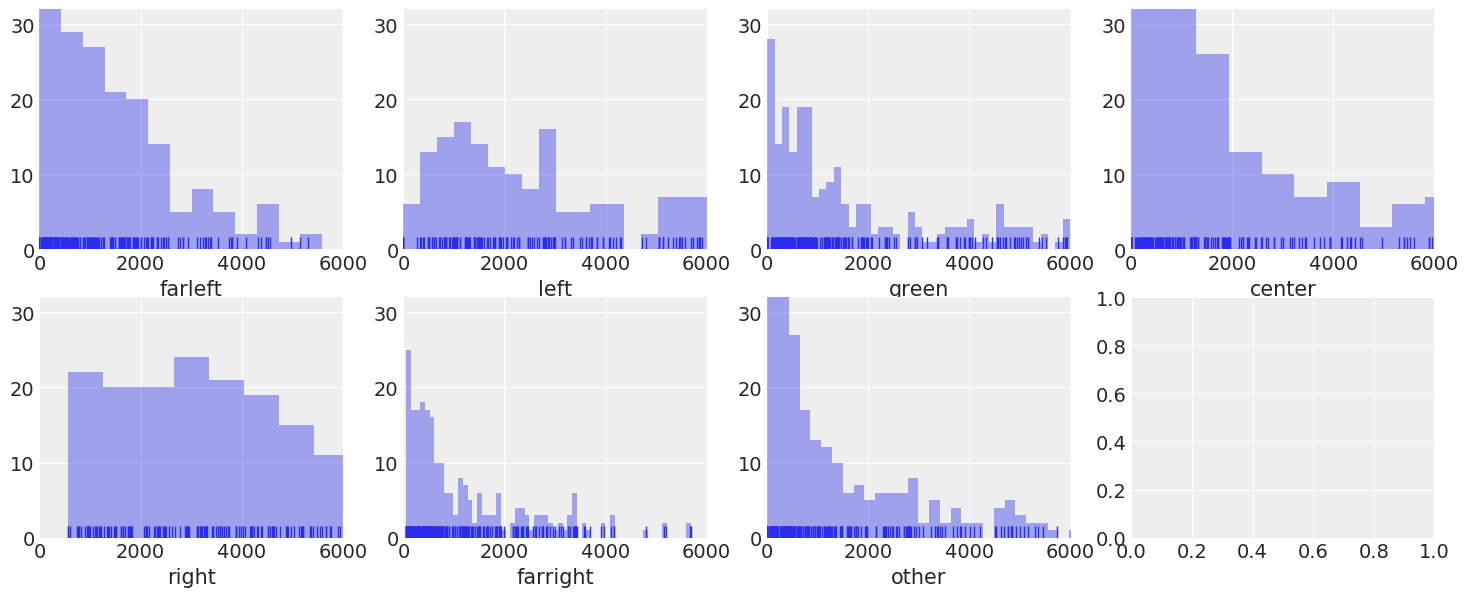

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(18, 7))
i = 0
for line in axes:
    for col in line:
        try:
            sns.distplot(d[PARTIES[i]], bins=60, kde=False, rug=True, ax=col)
            col.set_xlim([0, 6_000])
            col.set_ylim([0, 32])
            i += 1
        except IndexError:
            continue

That's not the best plot, but we can see that farleft, green and center do have a tendency to zero-inflation. The zero inflation comes from the fact that sometimes, some parties don't compete in a given election. Here, this process is simulated exactly like it happened in reality for the four elections in our dataset - thanks to the variable `parties_available`. So, during the four elections, some parties are not available in all or some districts. Now, how can we model this mixed process?

First, let's define index variables:

In [7]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)

type_id, types = d.type.factorize(sort=True)
Ntypes = len(types)

Nparties = len(PARTIES) - 1
N = d.N.values
R_obs = d[PARTIES].values

# which parties are available for choice
# huge value for missing parties, so that probability is 0 after softmax:
parties_available = (
    d[PARTIES]
    .astype(bool)
    .astype(int)
    .iloc[:, :-1]
    .replace(to_replace=0, value=50_000)
    .values
)
parties_available

array([[    1,     1,     1,     1,     1,     1],
       [    1, 50000,     1,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1],
       ...,
       [    1,     1,     1, 50000,     1,     1],
       [    1,     1, 50000,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1]])

Then we add a predictor to the dataset, which is the unemployment rate in Paris on a quarterly basis:

In [8]:
unemp = pd.read_excel(
    "../data/predictors/chomage-zone-demploi-2003-2019.xls",
    header=5,
    sheet_name="txcho_ze",
)
unemp = unemp[unemp["LIBZE2010"] == "Paris"].iloc[:, 4:].T
unemp.columns = ["unemployment"]

# as timestamps variables:
unemp.index = pd.PeriodIndex(start=unemp.index[0], periods=len(unemp), freq="Q")
unemp

unemployment
2003Q1           8.4
2003Q2           8.7
2003Q3           8.6
2003Q4           9.0
2004Q1           9.2
...              ...
2018Q2           7.8
2018Q3           7.8
2018Q4           7.5
2019Q1           7.4
2019Q2           7.2

[66 rows x 1 columns]

Now ne need to import the poll aggregation for each election. This will be our baseline for each party in each district:

In [9]:
train_polls = pd.read_excel(
    "../data/polls_1st_round/aggregated_polls.xlsx", index_col=0
)

test_polls = pd.read_excel(
    "/Users/alex_andorra/repos/contesdefaits/modeles/euro/agg_polls_euro2019.xlsx"
).iloc[-1]
test_polls = test_polls.drop(["souv", "other"])
test_polls.index = train_polls.columns[1:]
test_polls["type"] = "europeennes"

aggregated_polls = train_polls.append(test_polls, ignore_index=True)
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].div(100)
aggregated_polls.round(2)

type dateelection  samplesize_agg  farleft_agg  left_agg  \
0      president   2007-04-22            1513         0.03      0.24   
1   legislatives   2007-06-10             916         0.07      0.28   
2     municipale   2008-03-09             755         0.04      0.45   
3    europeennes   2009-06-07            2287         0.13      0.20   
4     regionales   2010-03-14             907         0.10      0.29   
5      president   2012-04-22            1400         0.14      0.28   
6   legislatives   2012-06-10            1193         0.08      0.32   
7     municipale   2014-03-23             977         0.06      0.38   
8    europeennes   2014-05-25            3248         0.08      0.17   
9     regionales   2015-12-06            1749         0.05      0.23   
10     president   2017-04-23            1555         0.19      0.08   
11  legislatives   2017-06-11            1299         0.12      0.08   
12   europeennes   2019-05-25            2221         0.08      0.05   

    green_agg  center_agg  right_agg  farright_agg  
0        0.01        0.19       0.27          0.14  
1        0.04        0.11       0.41          0.06  
2        0.06        0.08       0.33          0.02  
3        0.13        0.11       0.27          0.06  
4        0.14        0.05       0.29          0.09  
5        0.03        0.10       0.27          0.16  
6        0.05        0.03       0.34          0.15  
7        0.07        0.00       0.37          0.08  
8        0.09        0.10       0.21          0.23  
9        0.06        0.00       0.28          0.29  
10       0.00        0.24       0.19          0.22  
11       0.03        0.30       0.21          0.17  
12       0.08        0.23       0.14          0.25

As you probably noticed, the polls are in shares of support. Since our link function is softmax, we need to convert these proportions back on the real line (because the polls will be used before the link function appears in our model). It's [really easy to invert the softmax](https://math.stackexchange.com/questions/2786600/invert-the-softmax-function): we just have to take the log of each proportion and add an arbitrary constant -- here, we chose 1.

But hold on! There are two zeros in these data (for center party during the 2014 city-council and 2015 regional elections). It's due to the fact that this party was not running during these elections. When we'll take the logarithm of these zeros, we'll get minus infinity -- spoiler alert: our sampler won't like that. So we'll have to use a trick here.

Notice that the green party has a very low share of polls in the 2017 presidential elections. It's because there were some polls featuring the green party at the beginning of the race, but not anymore once the party dropped out. This is useful for us here: as a results, the poll aggregation is very near zero but not _exactly_ zero, so on the log scale it will give a very negative number but not minus infinity.

So here is our trick: let's replace the zeros for the center party by the value for the green party during the 2017 presidential election. This might seem like a cheap trick but it actually makes some conceptual sense: our model is concerned with the _latent_ support of each party's in the population. And in reality, neither the center nor the green parties were at _exactly_ zero percent support during these years -- they just had a very low support, which actually forced them to drop out and make alliances. So, replacing our perfect zeros with not-so-perfect zeros does make sense!

Here is how it looks in code:

In [10]:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].replace(
    to_replace=0,
    value=aggregated_polls.loc[
        aggregated_polls.dateelection == "2017-04-23", "green_agg"
    ].values[0],
)

# revert the softmax:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].apply(np.log) + 1

# standardize:
# aggregated_polls[PARTIES_AGG] = stdz(aggregated_polls[PARTIES_AGG])
aggregated_polls.round(2)

type dateelection  samplesize_agg  farleft_agg  left_agg  \
0      president   2007-04-22            1513        -2.63     -0.43   
1   legislatives   2007-06-10             916        -1.61     -0.29   
2     municipale   2008-03-09             755        -2.33      0.19   
3    europeennes   2009-06-07            2287        -1.04     -0.63   
4     regionales   2010-03-14             907        -1.32     -0.24   
5      president   2012-04-22            1400        -0.99     -0.29   
6   legislatives   2012-06-10            1193        -1.53     -0.14   
7     municipale   2014-03-23             977        -1.88      0.04   
8    europeennes   2014-05-25            3248        -1.58     -0.79   
9     regionales   2015-12-06            1749        -1.94     -0.47   
10     president   2017-04-23            1555        -0.67     -1.57   
11  legislatives   2017-06-11            1299        -1.14     -1.53   
12   europeennes   2019-05-25            2221        -1.48     -1.98   

    green_agg  center_agg  right_agg  farright_agg  
0       -3.95       -0.67      -0.30         -0.95  
1       -2.30       -1.20       0.12         -1.76  
2       -1.85       -1.51      -0.12         -2.82  
3       -1.01       -1.19      -0.30         -1.85  
4       -1.00       -2.06      -0.24         -1.40  
5       -2.68       -1.27      -0.32         -0.84  
6       -1.98       -2.58      -0.09         -0.88  
7       -1.73      -22.24      -0.01         -1.50  
8       -1.42       -1.33      -0.54         -0.46  
9       -1.84      -22.24      -0.27         -0.24  
10     -22.24       -0.44      -0.64         -0.49  
11      -2.51       -0.19      -0.56         -0.75  
12      -1.49       -0.48      -0.95         -0.40

And now we combine all district- and city-level predictors as well as polls and election results into the same dataframe:

In [11]:
# add quarters to results dataframe:
d.index = pd.DatetimeIndex(d["date"].values).to_period("Q")
d.index.name = "quarter"
# merge with city-level unemployment:
d = d.join(unemp).sort_values(["arrondissement", "date"]).reset_index(drop=True)

# join polling aggregation:
d = d.merge(
    aggregated_polls.drop("type", 1),
    left_on="date",
    right_on="dateelection",
    how="left",
).drop("dateelection", 1)
d

date  ville  arrondissement      N  farleft   left  green  center  \
0   2007-04-22  Paris               1   3043       79    841     68     682   
1   2007-06-10  Paris               1   2271       81      0    655     272   
2   2008-03-09  Paris               1   2252       28    841    161     195   
3   2009-06-07  Paris               1   2119      112    270    607     170   
4   2010-03-14  Paris               1   2173      132    484    466      79   
..         ...    ...             ...    ...      ...    ...    ...     ...   
235 2014-03-23  Paris              20  36832     3814  13738   4014       0   
236 2014-05-25  Paris              20  32885     3333   7086   6365    2826   
237 2015-12-06  Paris              20  36388     4518  13565   5442       0   
238 2017-04-23  Paris              20  81043    25797  11281      0   24790   
239 2017-06-11  Paris              20  51943    10446   9681   7026    5885   

     right  farright  ...  incumbent year_weights unemployment  \
0     1196       139  ...      right     0.332566          7.8   
1     1141        53  ...      right     0.332566          7.8   
2      971        56  ...       left     0.367573          6.6   
3      735        52  ...       left     0.406264          7.9   
4      789       117  ...       left     0.449029          8.2   
..     ...       ...  ...        ...          ...          ...   
235   7684      2755  ...       left     0.670096          8.7   
236   4017      3072  ...      right     0.670096          8.8   
237   6177      3686  ...       left     0.740633          8.7   
238  10360      4800  ...       left     0.904762          8.0   
239   3890      2213  ...       left     0.904762          8.0   

     samplesize_agg  farleft_agg  left_agg  green_agg  center_agg  right_agg  \
0              1513    -2.633513 -0.432471  -3.950292   -0.670963  -0.296018   
1               916    -1.613136 -0.288538  -2.295177   -1.196553   0.116238   
2               755    -2.327655  0.190572  -1.849138   -1.513482  -0.116553   
3              2287    -1.040641 -0.628886  -1.013539   -1.192074  -0.299655   
4               907    -1.319981 -0.240301  -0.996263   -2.061018  -0.240266   
..              ...          ...       ...        ...         ...        ...   
235             977    -1.884055  0.037657  -1.727255  -22.243938  -0.005215   
236            3248    -1.582788 -0.790411  -1.420928   -1.334419  -0.537229   
237            1749    -1.943570 -0.473766  -1.836909  -22.243938  -0.268955   
238            1555    -0.667318 -1.565596 -22.243938   -0.437694  -0.640817   
239            1299    -1.144984 -1.528224  -2.510045   -0.191539  -0.560378   

     farright_agg  
0       -0.946153  
1       -1.763649  
2       -2.824834  
3       -1.854871  
4       -1.398709  
..            ...  
235     -1.496337  
236     -0.460404  
237     -0.241968  
238     -0.493163  
239     -0.747776  

[240 rows x 22 columns]

Ok, everything's ready, let's run our model! This a varying-effects model that takes into account not only the variation in slopes and intercepts, but also accounts for the *covariation between slopes and intercepts* -- it exploits additional information about the population in order to shrink in both dimensions.

In [ ]:
# munic2020: update unemployment, binder, all districts and all parties, distrib/forest per district)
# Slack (weaknesses: time-ignorant, under-estimates uncertainty, ignores polling errors)
# rethinking Carnet --> State-space Model / HMM (manages to add time-awareness and uncertainty?)

In [12]:
with pm.Model() as m_dos_effects:
    mus_parties = []
    log_unemployment = stdz(np.log(d.unemployment)).values
    for p_id, p in enumerate(PARTIES_AGG):
        stdz_polls = stdz(d[p]).values

        if p in ["left_agg", "right_agg"]:
            sd_dist = pm.Exponential.dist(1.0)
            packed_chol = pm.LKJCholeskyCov(
                f"pchol_district_p{p_id}", eta=4, n=4, sd_dist=sd_dist
            )

            # compute covariance matrix:
            chol = pm.expand_packed_triangular(n=4, packed=packed_chol, lower=True)
            cov = pm.math.dot(chol, chol.T)

            # extract rho and standard deviations:
            sigma_district = pm.Deterministic(
                f"sigma_district_p{p_id}", tt.sqrt(tt.diag(cov))
            )
            corr = tt.diag(sigma_district ** -1).dot(
                cov.dot(tt.diag(sigma_district ** -1))
            )
            r = pm.Deterministic(
                f"Rho_district_p{p_id}", corr[np.triu_indices(n=4, k=1)]
            )

            # average itc and slopes:
            β = pm.Normal(
                f"β_p{p_id}",
                mu=np.array([-1.4, 0.0, 0.1, 0.0]),
                sd=np.array([0.5, 0.05, 0.05, 0.5]),
                shape=4,
            )

            # population of varying effects:
            β_district = pm.MvNormal(
                f"β_district_p{p_id}", mu=β, chol=chol, shape=(Ndistricts, 4)
            )
            type_effect = pm.Normal(
                f"type_effect_p{p_id}", mu=0.0, sigma=0.05, shape=Ntypes
            )

            if p == "right_agg":
                # linear model:
                mus_parties.append(
                    β_district[district_id, 0]
                    + type_effect[type_id]
                    + β_district[district_id, 1] * log_unemployment
                    + β_district[district_id, 2] * stdz_polls
                    + β_district[district_id, 3] * right_inc
                )
            else:
                mus_parties.append(
                    β_district[district_id, 0]
                    + type_effect[type_id]
                    + β_district[district_id, 1] * log_unemployment
                    + β_district[district_id, 2] * stdz_polls
                    + β_district[district_id, 3] * left_inc
                )

        else:
            sd_dist = pm.Exponential.dist(1.0)
            packed_chol = pm.LKJCholeskyCov(
                f"pchol_district_p{p_id}", eta=4, n=3, sd_dist=sd_dist
            )
            chol = pm.expand_packed_triangular(n=3, packed=packed_chol, lower=True)
            cov = pm.math.dot(chol, chol.T)
            sigma_district = pm.Deterministic(
                f"sigma_district_p{p_id}", tt.sqrt(tt.diag(cov))
            )
            corr = tt.diag(sigma_district ** -1).dot(
                cov.dot(tt.diag(sigma_district ** -1))
            )
            r = pm.Deterministic(
                f"Rho_district_p{p_id}", corr[np.triu_indices(n=3, k=1)]
            )

            if p == "center_agg":
                β = pm.Normal(
                    f"β_p{p_id}",
                    mu=np.array([-1.4, 0.0, 0.1]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    shape=3,
                )
            elif p in ["farleft_agg", "green_agg"]:
                β = pm.Normal(
                    f"β_p{p_id}",
                    mu=np.array([-1.9, 0.0, 0.1]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    shape=3,
                )
            elif p == "farright_agg":
                β = pm.Normal(
                    f"β_p{p_id}",
                    mu=np.array([-2.7, 0.0, 0.0]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    shape=3,
                )
            β_district = pm.MvNormal(
                f"β_district_p{p_id}", mu=β, chol=chol, shape=(Ndistricts, 3)
            )
            type_effect = pm.Normal(
                f"type_effect_p{p_id}", mu=0.0, sigma=0.05, shape=Ntypes
            )
            mus_parties.append(
                β_district[district_id, 0]
                + type_effect[type_id]
                + β_district[district_id, 1] * log_unemployment
                + β_district[district_id, 2] * stdz_polls
            )

    mus_parties = tt.as_tensor_variable(mus_parties).T
    # account for polling errors, media narratives, “October surprises":
    noisy_mus = pm.Normal("noisy_mus", mus_parties, 0.08, shape=mus_parties.tag.test_value.shape)
    # zero-inflation process:
    # push non-available parties towards -inf:
    noisy_mus = parties_available * noisy_mus
    # append last category:
    # vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-3.0))
    vary_pivot = pm.Normal("vary_pivot", mu=-3.0, sigma=0.05, shape=(len(d), 1))
    noisy_mus = tt.horizontal_stack(noisy_mus, vary_pivot)

    # preferences of each district, for all elections:
    p_district = pm.Deterministic("p_district", tt.nnet.softmax(noisy_mus))

    R = pm.Multinomial("R", n=N, p=p_district, observed=R_obs)
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

In [14]:
with m_dos_effects:
    trace_dos_effects = pm.sample(
        1000, tune=3000, cores=6, chains=4, random_seed=RANDOM_SEED, init="adapt_diag"
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [vary_pivot, noisy_mus, type_effect_p5, β_district_p5, β_p5, pchol_district_p5, type_effect_p4, β_district_p4, β_p4, pchol_district_p4, type_effect_p3, β_district_p3, β_p3, pchol_district_p3, type_effect_p2, β_district_p2, β_p2, pchol_district_p2, type_effect_p1, β_district_p1, β_p1, pchol_district_p1, type_effect_p0, β_district_p0, β_p0, pchol_district_p0]


In [15]:
az.summary(trace_dos_effects, round_to=2)

mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
β_p0[0]            -2.64  0.23   -3.08    -2.24        0.0      0.0   5471.89   
β_p0[1]            -0.10  0.05   -0.20    -0.01        0.0      0.0   5511.64   
β_p0[2]             0.34  0.03    0.28     0.39        0.0      0.0   4253.20   
β_district_p0[0,0] -3.02  0.05   -3.11    -2.93        0.0      0.0   2956.18   
β_district_p0[0,1] -0.41  0.06   -0.52    -0.31        0.0      0.0   3014.48   
...                  ...   ...     ...      ...        ...      ...       ...   
p_district[239,2]   0.14  0.00    0.13     0.14        0.0      0.0   4426.18   
p_district[239,3]   0.12  0.00    0.11     0.12        0.0      0.0   4266.87   
p_district[239,4]   0.08  0.00    0.07     0.08        0.0      0.0   4062.38   
p_district[239,5]   0.04  0.00    0.04     0.05        0.0      0.0   4376.97   
p_district[239,6]   0.24  0.00    0.24     0.25        0.0      0.0   3945.51   

                     ess_sd  ess_bulk  ess_tail  r_hat  
β_p0[0]             5471.89   5846.87   3395.37    1.0  
β_p0[1]             4912.98   5495.28   3470.34    1.0  
β_p0[2]             4253.20   4755.76   3280.10    1.0  
β_district_p0[0,0]  2954.91   2962.07   3538.15    1.0  
β_district_p0[0,1]  2965.05   3010.19   3493.18    1.0  
...                     ...       ...       ...    ...  
p_district[239,2]   4423.11   4427.95   3004.32    1.0  
p_district[239,3]   4266.87   4270.08   2456.27    1.0  
p_district[239,4]   4057.32   4041.19   2630.74    1.0  
p_district[239,5]   4373.34   4383.24   2418.24    1.0  
p_district[239,6]   3945.28   3962.19   2642.48    1.0  

[3898 rows x 11 columns]

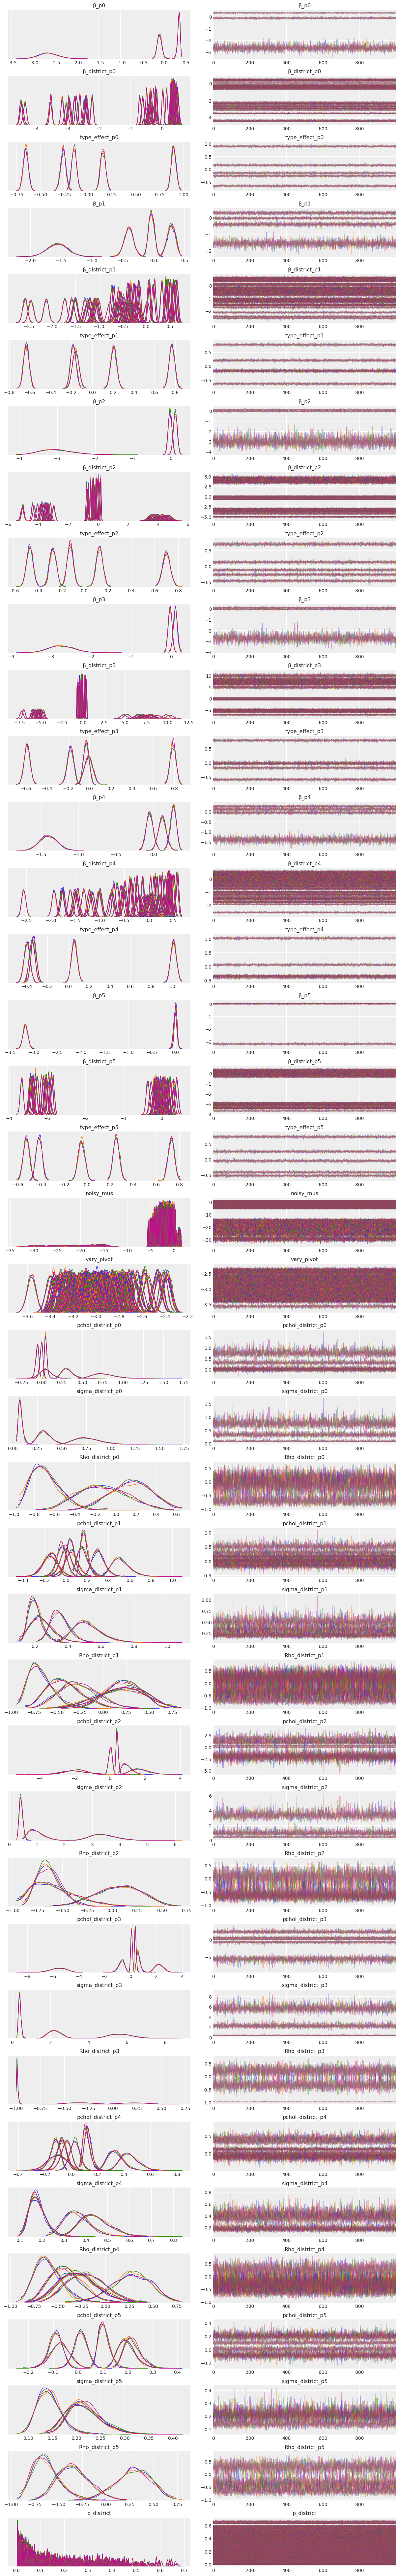

In [16]:
az.plot_trace(trace_dos_effects, compact=True);

In [110]:
share_est = trace_dos_effects["p_district"]
share_mean = share_est.mean(0)

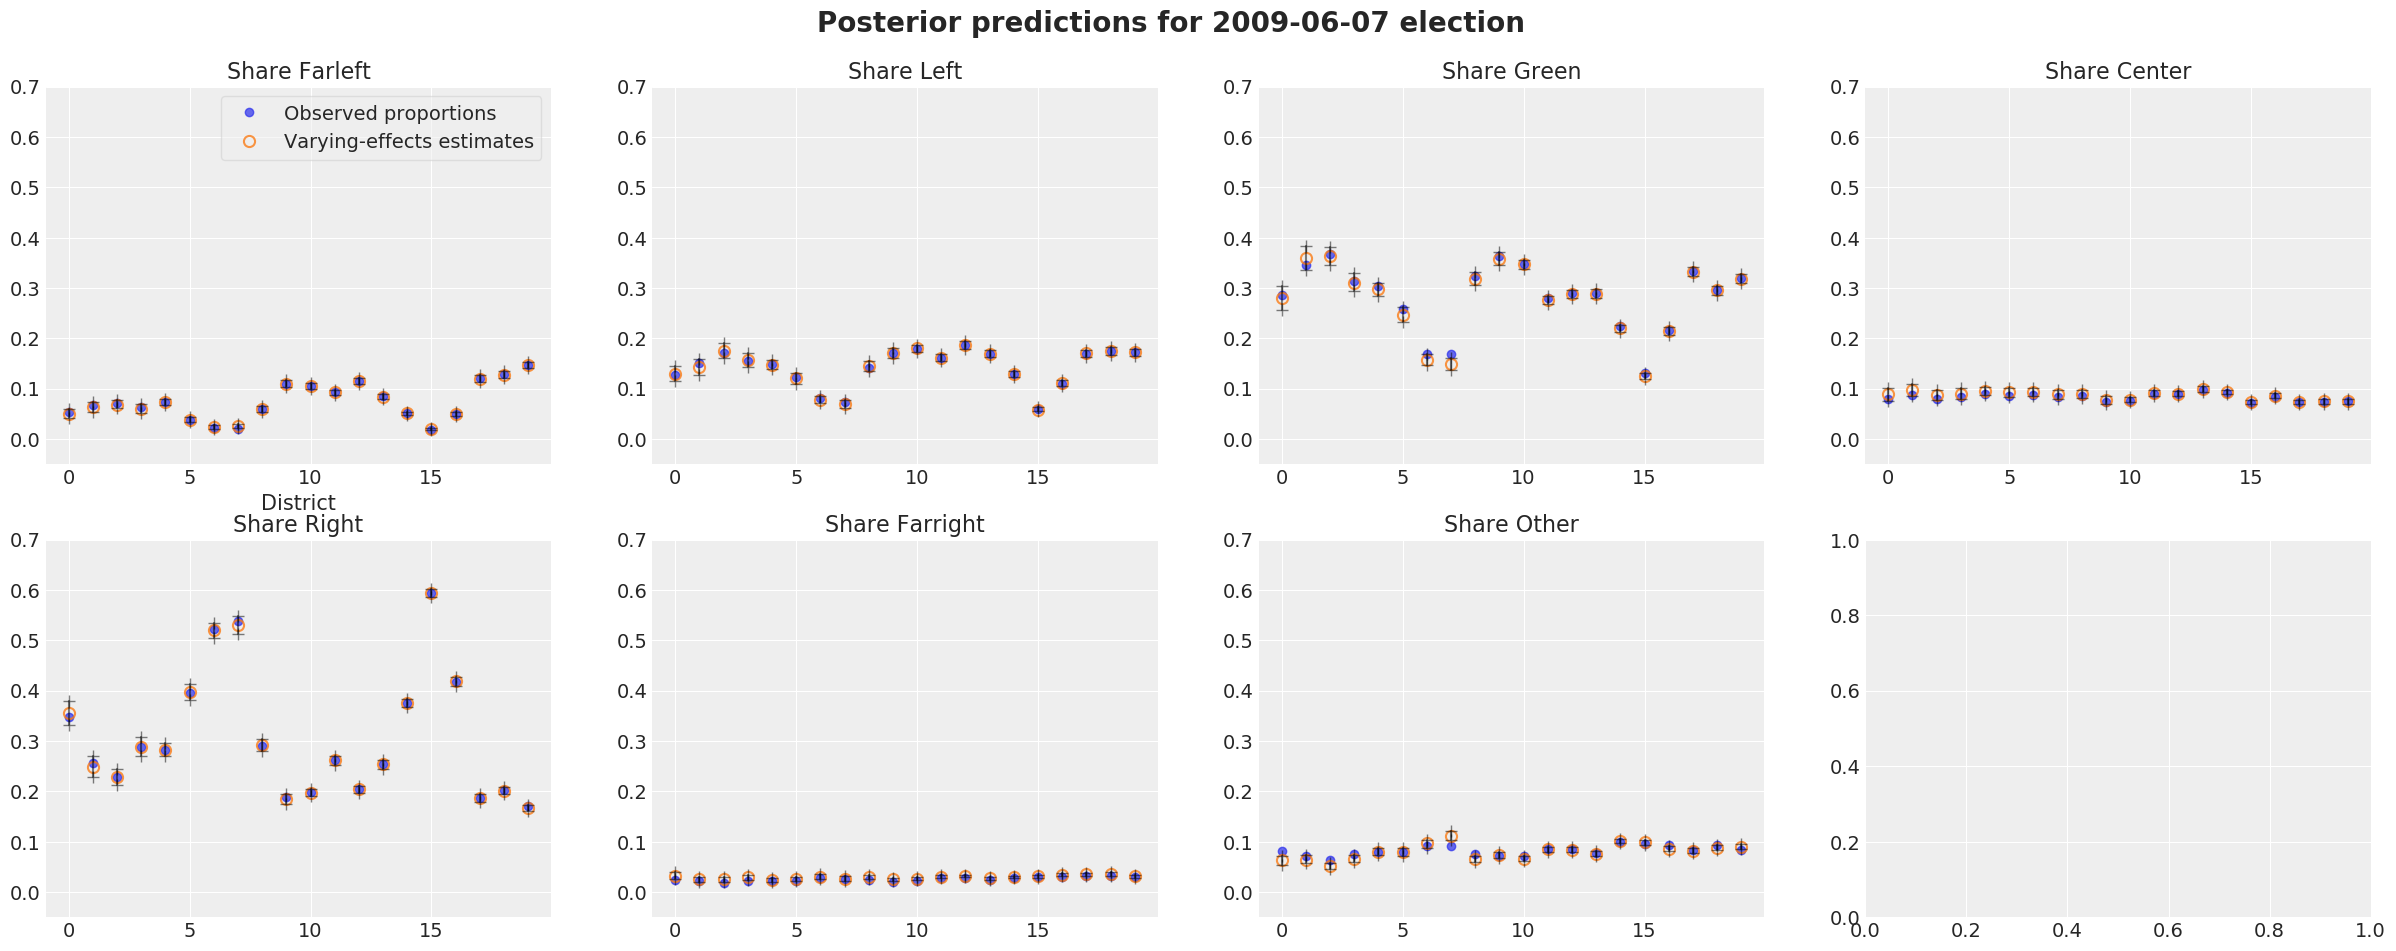

In [126]:
election = np.random.choice(d.date.unique(), replace=False)
election_mask = d.date == election
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
for i, ax in enumerate(axes.flat):
    try:
        ax.plot(
            np.arange(Ndistricts),
            d.loc[election_mask, PARTIES[i]] / d.loc[election_mask, "N"],
            "o",
            ms=6,
            alpha=0.7,
            label="Observed proportions",
        )
        ax.plot(
            np.arange(Ndistricts),
            share_mean[election_mask, i],
            "o",
            fillstyle="none",
            ms=8,
            markeredgewidth=1.5,
            alpha=0.8,
            label="Varying-effects estimates",
        )
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hpd(share_est[:, election_mask, i], credible_interval=0.99).T,
            "k-+",
            ms=8,
            alpha=0.5,
        )
        ax.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
        ax.set_title(f"Share {PARTIES[i].title()}")
        ax.set_ylim([-0.05, 0.7])
        if i == 0:
            ax.set_xlabel("District")
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    f"Posterior predictions for {np.datetime_as_string(election, unit='D')} election",
    y=0.95,
    size=20,
    weight="bold",
);

In [41]:
with open("trace_dos_effects.pkl", "wb") as f:
    pickle.dump({"model": m_dos_effects, "trace": trace_dos_effects}, f)

In [12]:
with open("trace_dos_effects.pkl", "rb") as f:
    data = pickle.load(f)
m_dos_effects, trace_dos_effects = data["model"], data["trace"]
idata = az.from_pymc3(trace_dos_effects)
post = idata.posterior

In [13]:
test_unemployment = (
    (np.log(unemp["2019Q2"]) - np.log(d["unemployment"]).mean())
    / np.log(d["unemployment"]).std()
).iloc[0, 0]
post_preds = []

for p_id, p in enumerate(PARTIES_AGG):
    test_polls = aggregated_polls.loc[
        aggregated_polls.dateelection == "2019-05-25", p
    ].values[0]
    test_polls = (test_polls - d[p].mean()) / d[p].std()

    post_preds.append(
        trace_dos_effects[f"β_district_p{p_id}"][:, :, 0]
        + trace_dos_effects[f"type_effect_p{p_id}"][:, 0, None]
        + trace_dos_effects[f"β_district_p{p_id}"][:, :, 1] * test_unemployment
        + trace_dos_effects[f"β_district_p{p_id}"][:, :, 2] * test_polls
    )
post_preds = np.asarray(post_preds).T
noisy_post_preds = post_preds + pm.Normal.dist(mu=0., sigma=0.08).random(size=post_preds.shape)
noisy_post_preds.shape

(20, 4000, 6)

In [14]:
# vary_pivot = np.full(shape=(Ndistricts, 2000, 1), fill_value=-3.0)
#vary_pivot = trace_dos_effects["vary_pivot"].transpose([1, 0, 2])
vary_pivot = pm.Normal.dist(mu=-3.0, sigma=0.05).random(size=(Ndistricts, post_preds.shape[1], 1))
noisy_post_preds = np.c_[noisy_post_preds, vary_pivot]
noisy_post_preds.shape

(20, 4000, 7)

In [15]:
share_est = softmax(noisy_post_preds, axis=2)
share_mean = share_est.mean(1)
share_est.shape

(20, 4000, 7)

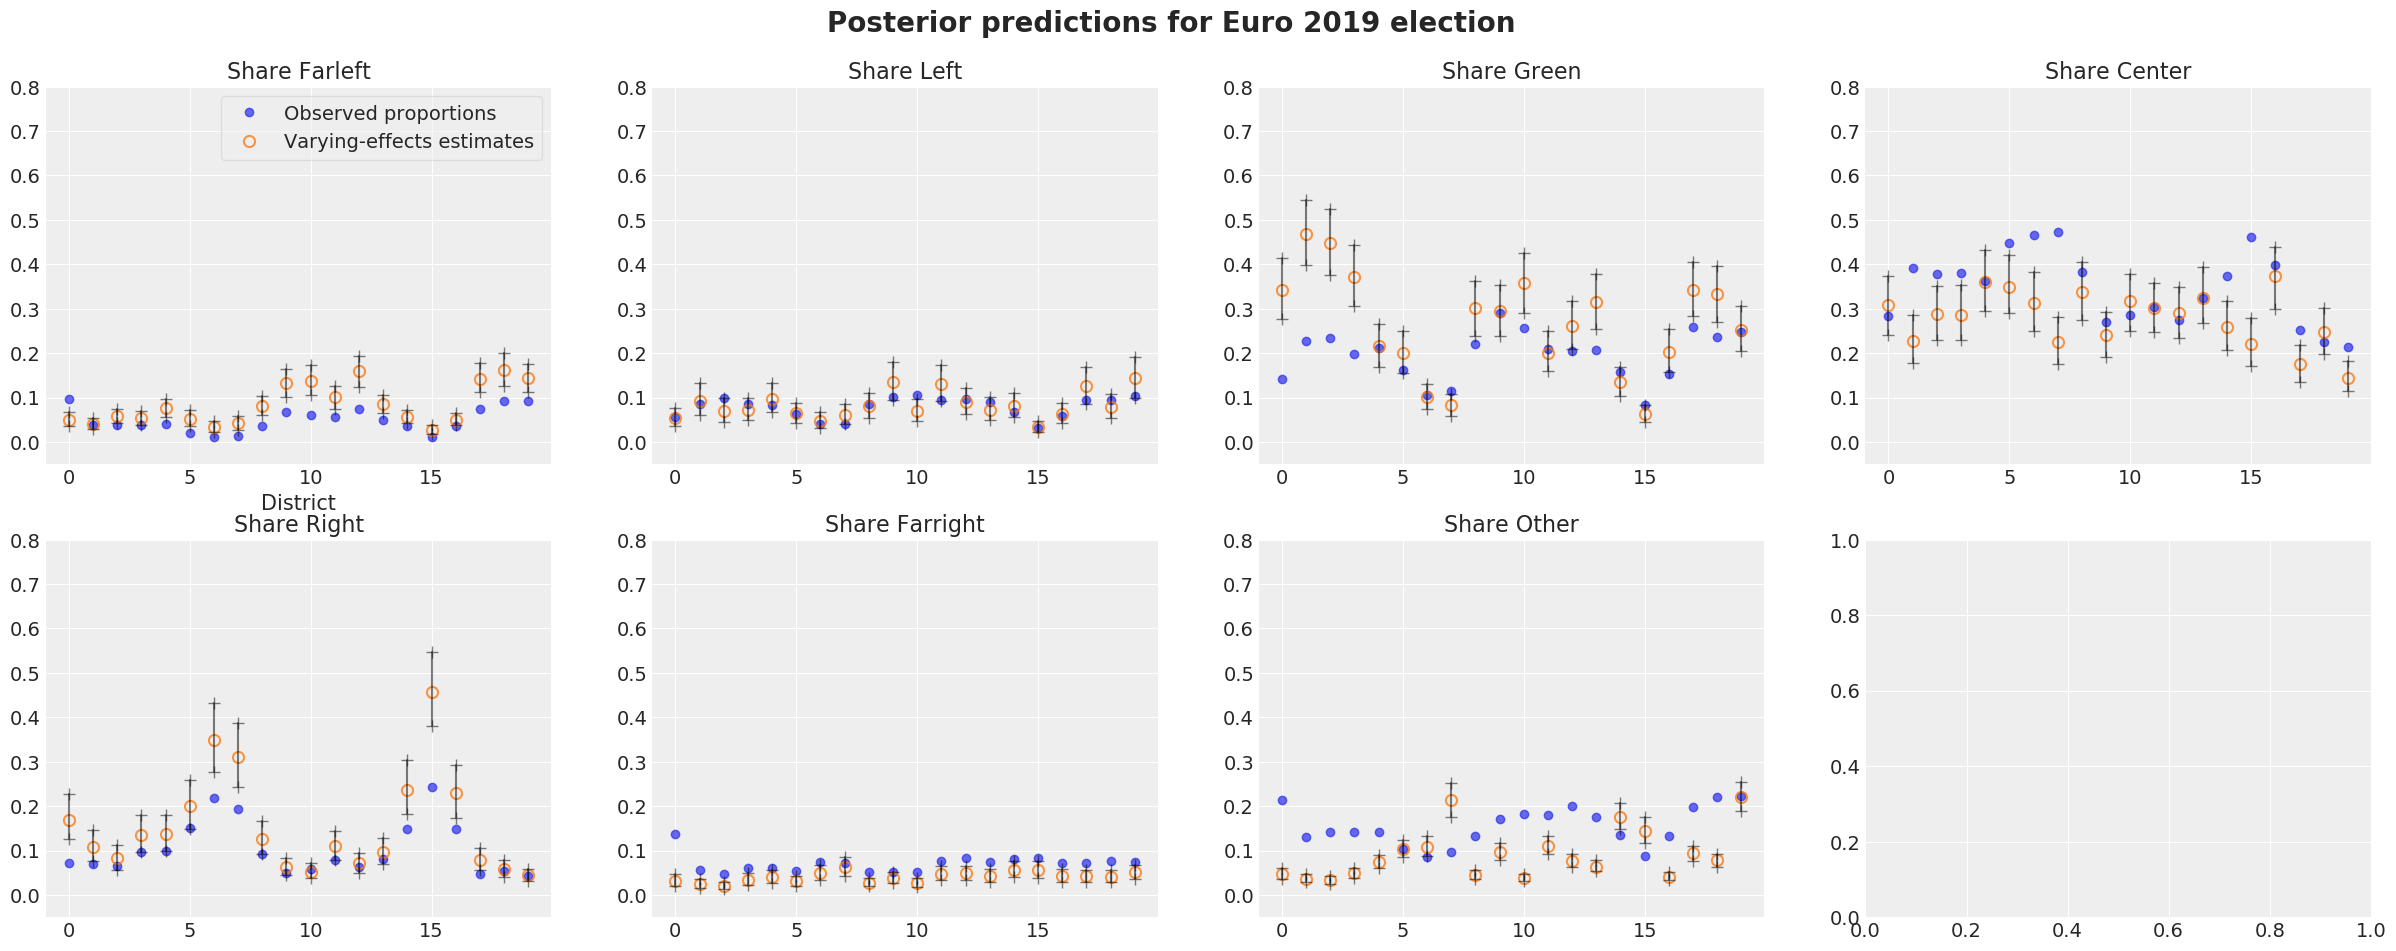

In [16]:
euro2019 = pd.read_excel(
    "../data/raw_election_results_1st_round/euro2019-districts.xlsx", index_col=0
)
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
for i, ax in enumerate(axes.flat):
    try:
        ax.plot(
            np.arange(Ndistricts),
            euro2019[PARTIES[i]] / euro2019["N"],
            "o",
            ms=6,
            alpha=0.7,
            label="Observed proportions",
        )
        ax.plot(
            np.arange(Ndistricts),
            share_mean[:, i],
            "o",
            fillstyle="none",
            ms=8,
            markeredgewidth=1.5,
            alpha=0.8,
            label="Varying-effects estimates",
        )
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hpd(share_est[:, :, i].T, credible_interval=0.99).T,
            "k-+",
            ms=8,
            alpha=0.5,
        )
        ax.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
        ax.set_title(f"Share {PARTIES[i].title()}")
        ax.set_ylim([-0.05, 0.8])
        if i == 0:
            ax.set_xlabel("District")
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    "Posterior predictions for Euro 2019 election", y=0.95, size=20, weight="bold",
);

In [52]:
district = np.random.randint(0, 20)

election = np.random.choice(d.date.unique(), replace=False)
election_mask = d.date == election

In [53]:
election_est = post.sel(p_district_dim_0=election_mask.nonzero()[0])
election_est["p_district"] = election_est["p_district"] * 100

preds = election_est["p_district"].stack(samples=('chain', 'draw'), districts=("p_district_dim_0", "p_district_dim_1")).to_pandas().reset_index(drop=True)
preds.columns = preds.columns.set_levels([districts, PARTIES])
preds.columns = preds.columns.rename(["districts", "parties"])
preds

districts        1                                                             \
parties     farleft left      green     center      right  farright     other   
0          3.963901  0.0  24.229841  13.019709  52.070744  2.951174  3.764631   
1          3.919350  0.0  23.961055  12.920771  52.246392  2.761773  4.190659   
2          3.988523  0.0  24.466148  11.922248  52.469917  3.285320  3.867843   
3          3.938031  0.0  25.225684  12.020545  51.035446  3.399180  4.381113   
4          4.032083  0.0  21.432375  13.352718  53.295554  3.891409  3.995862   
...             ...  ...        ...        ...        ...       ...       ...   
3995       4.630299  0.0  22.658234  12.243511  53.679678  2.572151  4.216127   
3996       5.031626  0.0  23.764494  12.846620  51.344351  2.831796  4.181112   
3997       3.892342  0.0  24.561241  13.477918  51.036479  2.857459  4.174562   
3998       3.986729  0.0  22.879158  13.163962  52.596318  3.026255  4.347578   
3999       4.475230  0.0  23.698756  13.617826  51.301143  2.956631  3.950414   

districts        2                   ...         19                      \
parties     farleft left      green  ...      right  farright     other   
0          5.143265  0.0  34.498811  ...  32.396540  3.082086  3.062180   
1          4.287540  0.0  34.997639  ...  32.533954  3.055949  2.900905   
2          4.742248  0.0  35.836819  ...  32.360146  3.309201  3.141487   
3          4.500794  0.0  35.477038  ...  32.273515  3.195054  3.142106   
4          4.623628  0.0  34.134394  ...  32.880191  3.375668  3.241418   
...             ...  ...        ...  ...        ...       ...       ...   
3995       5.009350  0.0  33.606774  ...  33.314932  3.014370  3.077683   
3996       5.049106  0.0  33.836134  ...  32.184659  3.004629  3.163211   
3997       4.846231  0.0  34.099937  ...  32.494105  3.045503  3.114837   
3998       5.077865  0.0  33.011227  ...  33.394749  3.167190  3.110986   
3999       5.277577  0.0  34.444915  ...  33.468484  3.119612  3.027558   

districts         20                                                       \
parties      farleft       left     green     center      right  farright   
0          11.191752  31.102844  6.648740  10.226846  26.051981  3.161224   
1          11.195979  31.727010  7.132978  10.097472  25.285579  3.094251   
2          11.059413  31.173783  7.040115  10.007795  26.081100  3.234941   
3          11.108763  31.770325  6.989920   9.859749  25.818406  3.079133   
4          10.892386  31.384759  6.897580  10.154519  26.077015  3.025917   
...              ...        ...       ...        ...        ...       ...   
3995       11.212496  30.964914  6.869691  10.034011  25.972199  3.161633   
3996       10.920396  31.451716  6.699546  10.088158  26.190357  3.116893   
3997       11.105225  31.902561  6.678478  10.120736  25.398621  3.028157   
3998       10.969201  31.300045  7.170334   9.934669  25.989637  2.892919   
3999       11.082148  30.964198  7.123453  10.166973  25.963657  3.039272   

districts             
parties        other  
0          11.616613  
1          11.466733  
2          11.402853  
3          11.373705  
4          11.567824  
...              ...  
3995       11.785057  
3996       11.532933  
3997       11.766222  
3998       11.743194  
3999       11.660300  

[4000 rows x 140 columns]

In [54]:
win_summary = {}
for dis in districts:
    df = preds[dis]
    winners = get_top_n(df, 1)
    
    probs = pd.DataFrame(winners.top1.value_counts(normalize=True).multiply(100).round().astype(int))
    probs.index.name = "winner"
    probs.columns = ["odds"]
    probs["low"], probs["high"], probs["mean"] = np.nan, np.nan, np.nan
    
    for party in probs.index:
        probs.loc[party, "low"], probs.loc[party, "high"] = az.hpd(df[party])
        probs.loc[party, "mean"] = df[party].mean()
        # assign means to color bins:
        bins_idx = np.digitize(probs.loc[party, "mean"], BINS)
        probs.loc[party, "color"] = COLORS[party][bins_idx]
    win_summary[dis] = probs.reset_index()

win_summary = pd.concat(win_summary).reset_index(level=1)
# keep only most probable winner:
win_summary = win_summary[win_summary.level_1 == 0].drop("level_1", axis=1)
win_summary.head()

winner  odds        low       high       mean    color
1  right   100  50.217830  53.949466  52.103889  #4292c6
2  right   100  37.397701  40.909389  39.140197  #6baed6
3  green   100  37.930927  40.566020  39.275660  #74c476
4  right   100  41.239463  44.081102  42.703676  #6baed6
5  right   100  41.065927  43.093597  42.141100  #6baed6

In [55]:
# https://github.com/gregoiredavid/france-geojson
paris_shape = gpd.read_file("../data/paris_shape.json").sort_values("code").reset_index(drop=True).set_index(districts)
paris_shape = pd.concat([paris_shape, win_summary], axis=1).reset_index()
paris_shape["winner"] = paris_shape["winner"].str.title()
paris_shape[["low", "high", "mean"]] = paris_shape[["low", "high", "mean"]].round(1)
geosource = GeoJSONDataSource(geojson=paris_shape.to_json()) 
paris_shape.head()

index   code                       nom  \
0      1  75101  Paris 1er Arrondissement   
1      2  75102  Paris 2e  Arrondissement   
2      3  75103  Paris 3e  Arrondissement   
3      4  75104  Paris 4e  Arrondissement   
4      5  75105  Paris 5e  Arrondissement   

                                            geometry winner  odds   low  high  \
0  POLYGON ((2.32576 48.86955, 2.32787 48.86986, ...  Right   100  50.2  53.9   
1  POLYGON ((2.35084 48.86334, 2.32787 48.86986, ...  Right   100  37.4  40.9   
2  POLYGON ((2.35009 48.86195, 2.35084 48.86334, ...  Green   100  37.9  40.6   
3  POLYGON ((2.34456 48.85399, 2.35009 48.86195, ...  Right   100  41.2  44.1   
4  POLYGON ((2.34456 48.85399, 2.36432 48.84617, ...  Right   100  41.1  43.1   

   mean    color  
0  52.1  #4292c6  
1  39.1  #6baed6  
2  39.3  #74c476  
3  42.7  #6baed6  
4  42.1  #6baed6

In [86]:
# https://towardsdatascience.com/walkthrough-mapping-basics-with-bokeh-and-geopandas-in-python-43f40aa5b7e9
# https://stackoverflow.com/questions/27586659/using-bokeh-to-plot-on-top-of-a-map
# https://stackoverflow.com/questions/57027969/bokeh-plots-an-empty-map-from-a-shapefile-converted-to-geojson-and-dont-know-wh
# https://automating-gis-processes.github.io/2017/lessons/L5/interactive-map-bokeh.html

p = bkp.figure(title = f'Predictions by district for {pd.to_datetime(election).date()} election',
               align="center",
               plot_height = 350,
               plot_width = 600,
               sizing_mode="scale_both", 
               title_location="above",
               tools = "",
               toolbar_location=None,
              )
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.axis.visible = False
p.outline_line_color = None
p.title.align = "center"
p.title.text_font_size = "1.2rem"
p.background_fill_color = '#e6e6e6'
p.border_fill_color = '#e6e6e6'

district_shapes = p.patches('xs','ys', source=geosource, fill_color="color", fill_alpha=1,
                   line_color = "gray", 
                   line_width = 0.75)
p.add_tools(HoverTool(renderers = [district_shapes],
                      tooltips = [("", 'Paris, District @index'), 
                                  ("Winner", '@winner, with @odds% chance'),
                                  ("Mean", "@mean{1.1} %"),
                                  ("94% HPD", '[@low{1.1} - @high{1.1}] % of votes')]))
show(p)

In [107]:
election_est = post.sel(p_district_dim_0=election_mask.nonzero()[0][district])
election_est["p_district"] = election_est["p_district"] * 100

#fig, axes = plt.subplots(2, 4, figsize=(30, 11))
#az.plot_forest(election_est, var_names=["p_district"], combined=True, backend="bokeh", figsize=(4, 9))
axes = az.plot_posterior(election_est, var_names=["p_district"], round_to=2, backend="bokeh", 
                         backend_kwargs=dict(align="center", min_border_left=0, min_border_right=0, outline_line_width=0, sizing_mode="scale_both", title_location="below", toolbar_location=None), 
                         show=False)
#axes[0].set_title(f"{pd.to_datetime(election).date()} Election -- {district + 1}th District");

# https://docs.bokeh.org/en/latest/docs/reference/models/layouts.html#bokeh.models.layouts.LayoutDOM.sizing_mode
# https://www.fullstackpython.com/blog/responsive-bar-charts-bokeh-flask-python-3.html

In [60]:
axes[0][0].renderers[0].data_source.data

{'x': array([0.81274722, 0.81983626, 0.82692531, 0.83401435, 0.8411034 ,
        0.84819244, 0.85528149, 0.86237053, 0.86945958, 0.87654863,
        0.88363767, 0.89072672, 0.89781576, 0.90490481, 0.91199385,
        0.9190829 , 0.92617194, 0.93326099, 0.94035004, 0.94743908,
        0.95452813, 0.96161717, 0.96870622, 0.97579526, 0.98288431,
        0.98997335, 0.9970624 , 1.00415144, 1.01124049, 1.01832954,
        1.02541858, 1.03250763, 1.03959667, 1.04668572, 1.05377476,
        1.06086381, 1.06795285, 1.0750419 , 1.08213095, 1.08921999,
        1.09630904, 1.10339808, 1.11048713, 1.11757617, 1.12466522,
        1.13175426, 1.13884331, 1.14593236, 1.1530214 , 1.16011045,
        1.16719949, 1.17428854, 1.18137758, 1.18846663, 1.19555567,
        1.20264472, 1.20973376, 1.21682281, 1.22391186, 1.2310009 ,
        1.23808995, 1.24517899, 1.25226804, 1.25935708, 1.26644613,
        1.27353517, 1.28062422, 1.28771327, 1.29480231, 1.30189136,
        1.3089804 , 1.31606945, 1.32315849,

In [136]:
for i, ax in enumerate(axes.flat):
    if ax:
        ax.title.text = f"{PARTIES[i].title()}"
        ax.title.align = "center"
        ax.title.text_font_size = "1rem"
        ax.background_fill_color = '#f2f2f2'
        ax.border_fill_color = '#f2f2f2'
        ax.xaxis.minor_tick_line_color = None
        if i == 1:
            ax.add_layout(Title(text=f"{pd.to_datetime(election).date()} Election -- {district + 1}th District", text_font_size = "1.2rem", align="center"), "above")
        for line in ax.renderers[:2]:
            line.glyph.line_color = COLORS[PARTIES[i]]
            line.glyph.line_width=2.5

In [137]:
select = Select(title="Predictions for district:", value="District 1", options=[f"District {d}" for d in districts])

In [139]:
layout = column(select, gridplot(axes.tolist(), toolbar_location=None))
bkp.show(layout)
# https://towardsdatascience.com/data-visualization-with-bokeh-in-python-part-ii-interactions-a4cf994e2512
# https://stackoverflow.com/questions/50603077/bokeh-select-widget-does-not-update-plot
# https://stackoverflow.com/questions/46831371/how-to-update-plot-by-setting-source-with-select-widget-in-bokeh